# Imports. Functions. Constants.

In [2]:
from pyxll import plot, xl_func
import seaborn as sns

In [32]:
from itertools import cycle

import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
import matplotlib.ticker as mticker

from scipy.stats import ttest_ind, levene, bartlett, shapiro

from sklearn.model_selection import train_test_split, cross_val_predict, GridSearchCV
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, f1_score, roc_curve, roc_auc_score

import catboost as cb
import optuna

In [2]:
def test(a, b):
    # normality test
    _, p_value_norm_a = shapiro(a)
    _, p_value_norm_b = shapiro(b)

    # dispersion test
    if p_value_norm_a < ALPHA and p_value_norm_b < ALPHA:
        _, p_value_disp = levene(a, b)
    else:
        _, p_value_disp = bartlett(a, b)

    # t-test
    if p_value_disp < ALPHA:
        _, p_value_ttest = ttest_ind(a, b, equal_var=False)
    else:
        _, p_value_ttest = ttest_ind(a, b, equal_var=True)

    # printing results
    print('t-тест Стьюдента:')
    print(f"p-value = {p_value_ttest}")
    if p_value_ttest < ALPHA:
        print('Отвергаем нулевую гипотезу.')
        print('Принимаем альтернативную гипотезу.')
        print('Средние двух выборок не равны.')
    else:
        print('Не отвергаем нулевую гипотезу.')
        print('Средние двух выборок равны.')

In [29]:
def objective_rf(trial):
    rf_param = {
        'n_estimators': trial.suggest_int('n_estimators', 100, 800, 50),
        'max_depth': trial.suggest_int('max_depth', 3, 12),
        'min_samples_split': trial.suggest_int('min_samples_split', 2, 50, 2),
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 96, 5),
        'max_features': trial.suggest_int('max_features', 2, 21)
    }
        
    model = RandomForestClassifier(**rf_param, random_state=45, warm_start=True, n_jobs=-1)
    model.fit(X_train, y_train)
    return f1_score(y_val, model.predict(X_val))

In [5]:
def objective_catboost(trial):
    params = {
        'iterations':
        trial.suggest_int('iterations', 500, 3000, 100),
        'learning_rate':
        trial.suggest_float('learning_rate', 0.001, 0.1),
        'depth':
        trial.suggest_int('depth', 1, 12),
        'l2_leaf_reg':
        trial.suggest_float('l2_leaf_reg', 0, 100),
        'random_strength':
        trial.suggest_float('random_strength', 0, 10),
        'one_hot_max_size':
        trial.suggest_int('one_hot_max_size', 2, 4),
        'boosting_type':
        trial.suggest_categorical('boosting_type', ['Ordered', 'Plain']),
        'bootstrap_type':
        trial.suggest_categorical('bootstrap_type',
                                  ['Bayesian', 'Bernoulli', 'MVS']),
        'loss_function':
        trial.suggest_categorical('loss_function', ['Logloss', 'CrossEntropy']),
        'colsample_bylevel':
        trial.suggest_float('colsample_bylevel', 0.01, 0.1),
    }

    if params['bootstrap_type'] == 'Bayesian':
        params['bagging_temperature'] = trial.suggest_float(
            'bagging_temperature', 0, 10)
    elif params['bootstrap_type'] == 'Bernoulli':
        params['subsample'] = trial.suggest_float('subsample', 0.1, 1)

    model = cb.CatBoostClassifier(**params, verbose=0)
    model.fit(train_pool)
    return f1_score(y_val, model.predict(val_pool))

In [6]:
def plot_roc_auc(y, pred):
    """
    Изображает ROC-кривую.
    """
    fpr, tpr, _ = roc_curve(y, pred)
    plt.figure()
    lw = 2
    plt.plot(
        fpr,
        tpr,
        color="darkorange",
        lw=lw,
        label='ROC-AUC = %0.4f' % roc_auc_score(y, pred),
    )
    plt.plot([0, 1], [0, 1], color="navy", lw=lw, linestyle="--")
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC кривая")
    plt.legend(loc="lower right")
    plt.show()

In [7]:
ALPHA = 0.05

# Data

In [8]:
data = pd.read_csv('heart.csv')
data.head()

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,40,M,ATA,140,289,0,Normal,172,N,0.0,Up,0
1,49,F,NAP,160,180,0,Normal,156,N,1.0,Flat,1
2,37,M,ATA,130,283,0,ST,98,N,0.0,Up,0
3,48,F,ASY,138,214,0,Normal,108,Y,1.5,Flat,1
4,54,M,NAP,150,195,0,Normal,122,N,0.0,Up,0


1. `Age`: age of the patient, years;  
2. `Sex`: sex of the patient:  
        M - Male,
        F - Female;  
3. `ChestPainType`: chest pain type:
        TA - Typical Angina,
        ATA - Atypical Angina,
        NAP - Non-Anginal Pain,
        ASY - Asymptomatic;
4. `RestingBP`: resting blood pressure, mm Hg;
5. `Cholesterol`: serum cholesterol, mm/dl;
6. `FastingBS`: fasting blood sugar:
        1 - if FastingBS > 120 mg/dl,
        0 - otherwise;
7. `RestingECG`: resting electrocardiogram results:
        Normal - Normal,
        ST - having ST-T wave abnormality (T wave inversions and/or ST elevation or depression of > 0.05 mV),
        LVH - showing probable or definite left ventricular hypertrophy by Estes' criteria;
8. `MaxHR`: maximum heart rate achieved, bpm;
9. `ExerciseAngina`: exercise-induced angina:
        Y - Yes,
        N - No;
10. `Oldpeak`: oldpeak = ST, Numeric value measured in depression;
11. `ST_Slope`: the slope of the peak exercise ST segment:
        Up: upsloping,
        Flat: flat,
        Down: downsloping;
12. **`HeartDisease`**: output class:
        1 - heart disease,
        0 - Normal.

In [9]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 918 entries, 0 to 917
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Age             918 non-null    int64  
 1   Sex             918 non-null    object 
 2   ChestPainType   918 non-null    object 
 3   RestingBP       918 non-null    int64  
 4   Cholesterol     918 non-null    int64  
 5   FastingBS       918 non-null    int64  
 6   RestingECG      918 non-null    object 
 7   MaxHR           918 non-null    int64  
 8   ExerciseAngina  918 non-null    object 
 9   Oldpeak         918 non-null    float64
 10  ST_Slope        918 non-null    object 
 11  HeartDisease    918 non-null    int64  
dtypes: float64(1), int64(6), object(5)
memory usage: 86.2+ KB


In [10]:
data.describe()

,Age,RestingBP,Cholesterol,FastingBS,MaxHR,Oldpeak,HeartDisease
count,918.000000,918.000000,918.000000,918.000000,918.000000,918.000000,918.000000
mean,53.510893,132.396514,198.799564,0.233115,136.809368,0.887364,0.553377
std,9.432617,18.514154,109.384145,0.423046,25.460334,1.066570,0.497414
min,28.000000,0.000000,0.000000,0.000000,60.000000,-2.600000,0.000000
25%,47.000000,120.000000,173.250000,0.000000,120.000000,0.000000,0.000000
50%,54.000000,130.000000,223.000000,0.000000,138.000000,0.600000,1.000000
75%,60.000000,140.000000,267.000000,0.000000,156.000000,1.500000,1.000000
max,77.000000,200.000000,603.000000,1.000000,202.000000,6.200000,1.000000


In [11]:
data.describe(include='object')

,Sex,ChestPainType,RestingECG,ExerciseAngina,ST_Slope
count,918,918,918,918,918
unique,2,4,3,2,3
top,M,ASY,Normal,N,Flat
freq,725,496,552,547,460


In [12]:
data[data.duplicated()]

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease


# Preprocessing

## rename

In [13]:
data = data.rename(
    {
        'Age': 'age',
        'RestingBP': 'resting_bp',
        'Cholesterol': 'cholesterol',
        'FastingBS': 'fasting_bs',
        'MaxHR': 'max_hr',
        'Oldpeak': 'oldpeak',
        'HeartDisease': 'heart_disease',
        'Sex': 'sex',
        'ChestPainType': 'chest_pain_type',
        'RestingECG': 'resting_ecg',
        'ExerciseAngina': 'exercise_angina',
        'ST_Slope': 'st_slope'
    },
    axis=1)
data.head()

,age,sex,chest_pain_type,resting_bp,cholesterol,fasting_bs,resting_ecg,max_hr,exercise_angina,oldpeak,st_slope,heart_disease
0,40,M,ATA,140,289,0,Normal,172,N,0.0,Up,0
1,49,F,NAP,160,180,0,Normal,156,N,1.0,Flat,1
2,37,M,ATA,130,283,0,ST,98,N,0.0,Up,0
3,48,F,ASY,138,214,0,Normal,108,Y,1.5,Flat,1
4,54,M,NAP,150,195,0,Normal,122,N,0.0,Up,0


## dtypes

In [14]:
cat_cols = list(data.select_dtypes('object').columns) + ['fasting_bs']

data[cat_cols[:-1]] = data.select_dtypes('object').astype('category')
data[['fasting_bs']] = data[['fasting_bs']].astype('category')

num_cols = list(data.select_dtypes(exclude='category').columns)

## Anomalies

### resting_bp == 0

In [15]:
data[data['resting_bp'] == 0]

,age,sex,chest_pain_type,resting_bp,cholesterol,fasting_bs,resting_ecg,max_hr,exercise_angina,oldpeak,st_slope,heart_disease
449,55,M,NAP,0,0,0,Normal,155,N,1.5,Flat,1


Удалим выброс.

In [16]:
data = data.drop(data[data['resting_bp'] == 0].index)

### cholesterol == 0

In [17]:
data[data['cholesterol'] == 0]

,age,sex,chest_pain_type,resting_bp,cholesterol,fasting_bs,resting_ecg,max_hr,exercise_angina,oldpeak,st_slope,heart_disease
293,65,M,ASY,115,0,0,Normal,93,Y,0.0,Flat,1
294,32,M,TA,95,0,1,Normal,127,N,0.7,Up,1
295,61,M,ASY,105,0,1,Normal,110,Y,1.5,Up,1
296,50,M,ASY,145,0,1,Normal,139,Y,0.7,Flat,1
297,57,M,ASY,110,0,1,ST,131,Y,1.4,Up,1
...,...,...,...,...,...,...,...,...,...,...,...,...
514,43,M,ASY,122,0,0,Normal,120,N,0.5,Up,1
515,63,M,NAP,130,0,1,ST,160,N,3.0,Flat,0
518,48,M,NAP,102,0,1,ST,110,Y,1.0,Down,1
535,56,M,ASY,130,0,0,LVH,122,Y,1.0,Flat,1


Для анализа отбросим, но оставим при построении модели.

In [18]:
data_eda = data.drop(data[data['cholesterol'] == 0].index)

# EDA

## num_cols

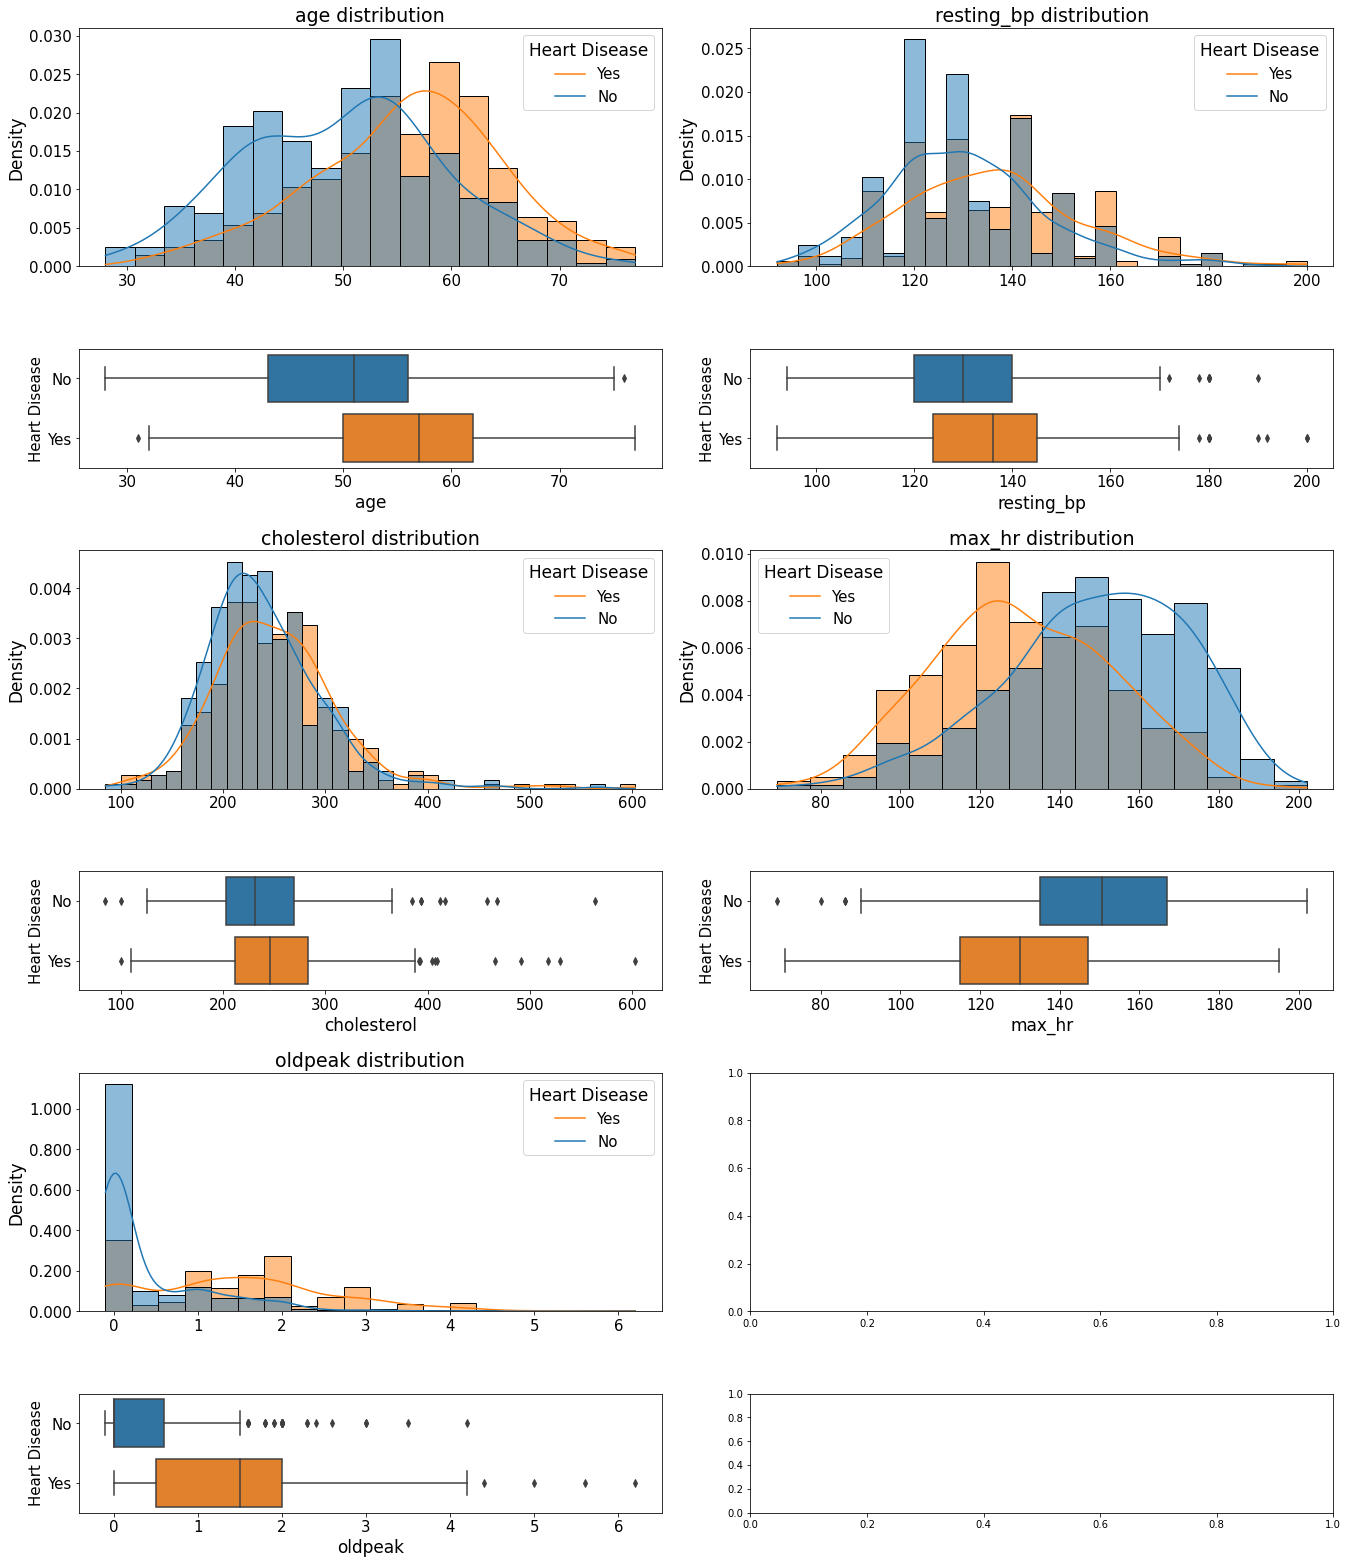

In [19]:
plt.rcParams['figure.figsize'] = (19, 22)
data_eda['heart_disease_cat'] = data_eda['heart_disease'].astype('category')
num_cols_cycle = cycle(num_cols[:-1])

fig, axs = plt.subplots(
    nrows=6,
    ncols=2,
    gridspec_kw={"height_ratios": (2 / 9, 1 / 9, 2 / 9, 1 / 9, 2 / 9, 1 / 9)})

for i in range(0, 5, 2):
    for j in range(2):
        if i == 4 and j == 1:
            continue
        col_name = next(num_cols_cycle)
        sns.histplot(data=data_eda,
                     x=col_name,
                     hue='heart_disease_cat',
                     kde=True,
                     stat='density',
                     ax=axs[i][j])
        sns.boxplot(data=data_eda,
                    x=col_name,
                    y='heart_disease_cat',
                    ax=axs[i + 1][j])
        axs[i][j].legend(['Yes', 'No'], title='Heart Disease', fontsize='15')
        plt.setp(axs[i][j].get_legend().get_title(), fontsize='17')

        axs[i][j].set_title(f'{col_name} distribution', fontsize=19)

        axs[i][j].set_ylabel('Density', fontsize=17)
        axs[i][j].set_xlabel('')
        axs[i + 1][j].set_ylabel('Heart Disease', fontsize=15)
        axs[i + 1][j].set_xlabel(col_name, fontsize=17)

        ticks_loc = axs[i][j].get_yticks().tolist()
        axs[i][j].yaxis.set_major_locator(mticker.FixedLocator(ticks_loc))
        axs[i][j].set_yticklabels(['{:,.3f}'.format(x) for x in ticks_loc],
                                  size=15)

        ticks_loc = axs[i][j].get_xticks().tolist()
        axs[i][j].xaxis.set_major_locator(mticker.FixedLocator(ticks_loc))
        axs[i][j].set_xticklabels(['{:,.0f}'.format(x) for x in ticks_loc],
                                  size=15)

        ticks_loc = axs[i + 1][j].get_yticks().tolist()
        axs[i + 1][j].yaxis.set_major_locator(mticker.FixedLocator(ticks_loc))
        axs[i + 1][j].set_yticklabels(['No', 'Yes'], size=15)

        ticks_loc = axs[i + 1][j].get_xticks().tolist()
        axs[i + 1][j].xaxis.set_major_locator(mticker.FixedLocator(ticks_loc))
        axs[i + 1][j].set_xticklabels(['{:,.0f}'.format(x) for x in ticks_loc],
                                      size=15)

plt.tight_layout(pad=1.7)
plt.show()

## cat_cols

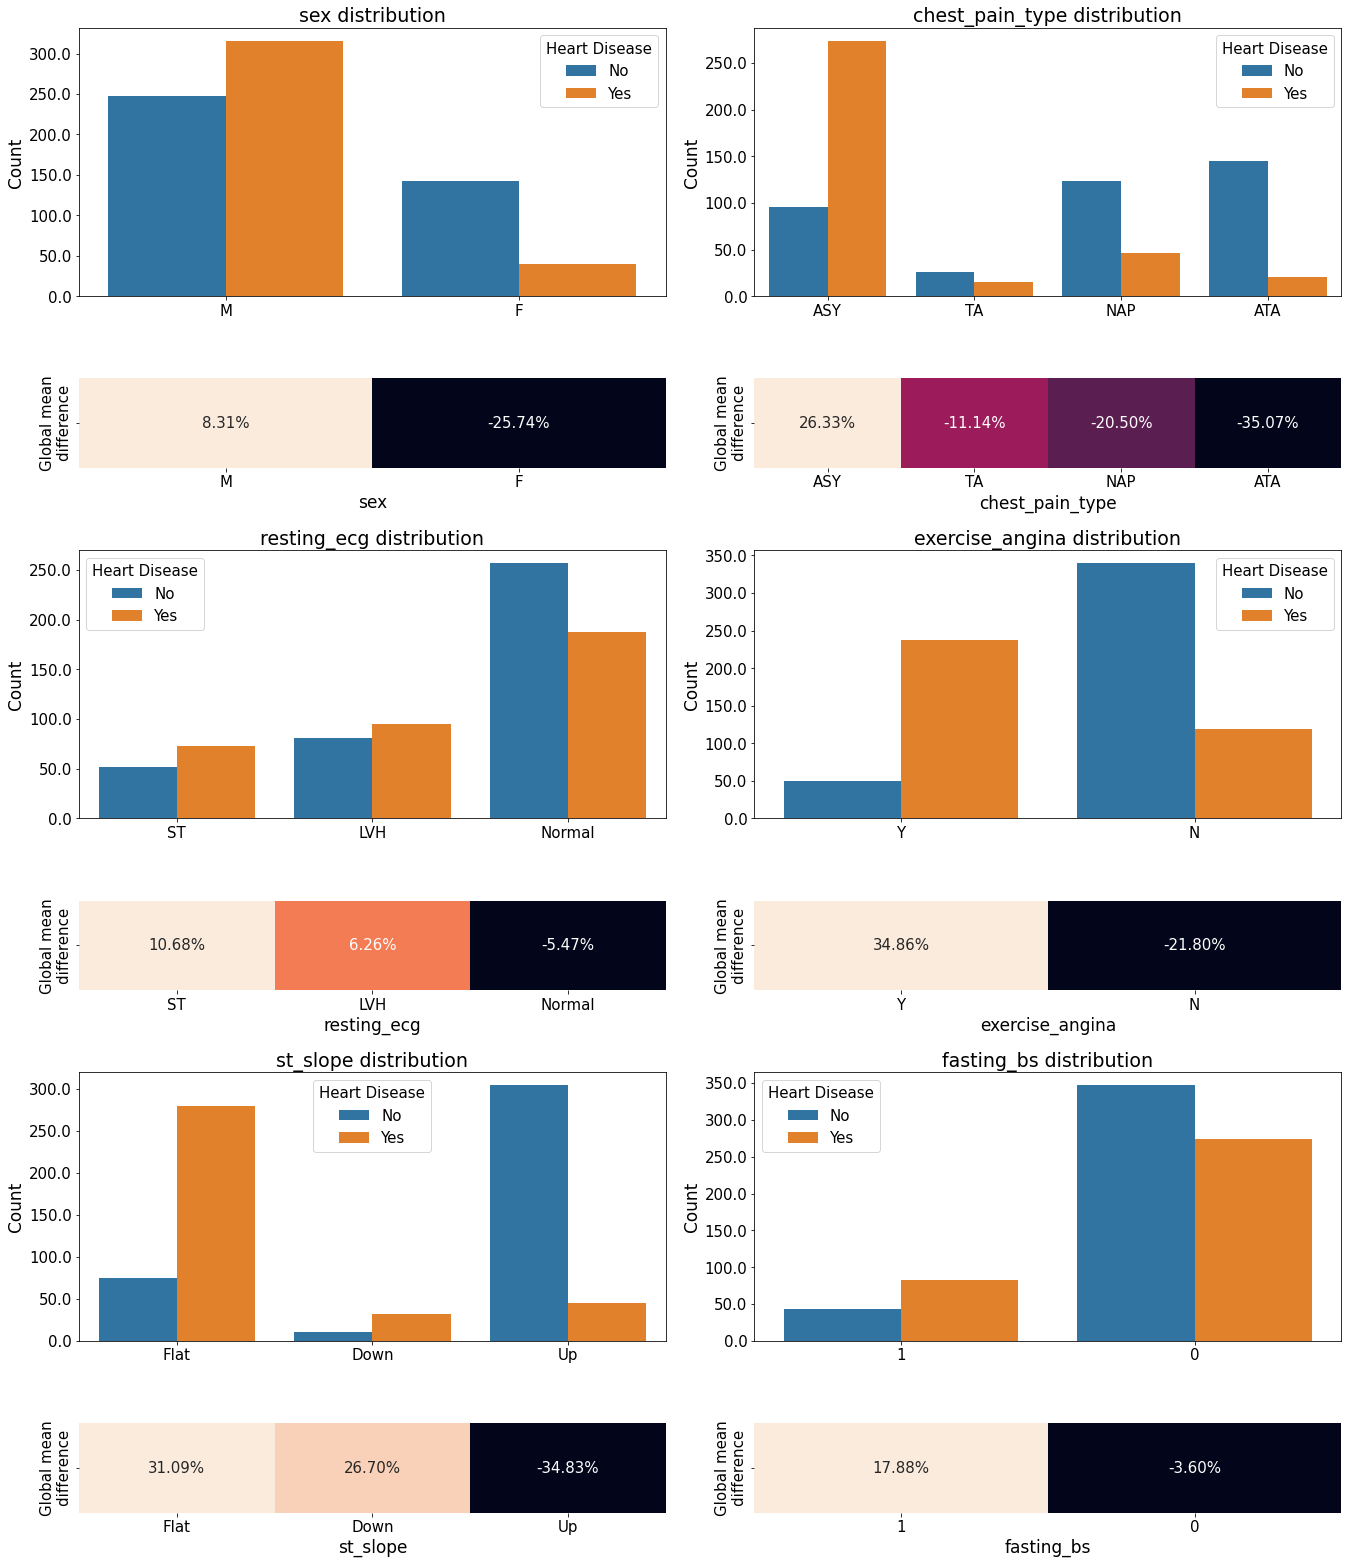

In [20]:
plt.rcParams['figure.figsize'] = (19, 22)
cat_cols_cycle = cycle(cat_cols)
fig, axs = plt.subplots(nrows=6,
                        ncols=2,
                        gridspec_kw={
                            "height_ratios":
                            (3 / 12, 1 / 12, 3 / 12, 1 / 12, 3 / 12, 1 / 12)
                        })

for i in range(0, 5, 2):
    for j in range(2):
        col_name = next(cat_cols_cycle)

        df_grouped = (data_eda.groupby(col_name)['heart_disease'].mean(
        ).sort_values(ascending=False)) - data_eda['heart_disease'].mean()

        sns.countplot(data=data_eda,
                      x=col_name,
                      hue='heart_disease_cat',
                      ax=axs[i][j],
                      order=df_grouped.index)

        sns.heatmap(df_grouped.values.reshape(1, -1),
                    annot=True,
                    annot_kws={"fontsize": 15},
                    cbar=False,
                    fmt='.2%',
                    ax=axs[i + 1][j],
                    xticklabels=df_grouped.index)
        axs[i][j].legend(['No', 'Yes'], title='Heart Disease', fontsize='15')
        plt.setp(axs[i][j].get_legend().get_title(), fontsize='15')

        axs[i][j].set_title(f'{col_name} distribution', fontsize=19)

        axs[i][j].set_ylabel('Count', fontsize=17)
        axs[i][j].set_xlabel('')
        axs[i + 1][j].set_ylabel('', fontsize=1)
        axs[i + 1][j].set_xlabel(col_name, fontsize=17)

        ticks_loc = axs[i][j].get_yticks().tolist()
        axs[i][j].yaxis.set_major_locator(mticker.FixedLocator(ticks_loc))
        axs[i][j].set_yticklabels(ticks_loc, size=15)
        axs[i][j].set_xticklabels(axs[i][j].get_xticklabels(), size=15)
        axs[i + 1][j].set_xticklabels(axs[i + 1][j].get_xticklabels(), size=15)
        axs[i + 1][j].set_yticklabels(['Global mean\ndifference  '], size=15)

plt.tight_layout(pad=1.7)
plt.show()

## correlations

<AxesSubplot:>

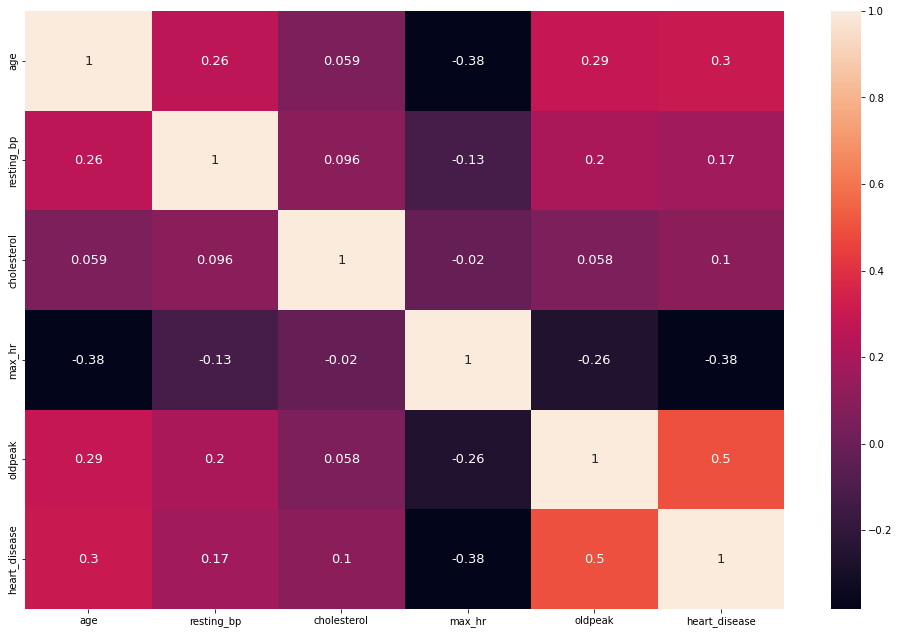

In [21]:
plt.rcParams['figure.figsize'] = (17, 11)
sns.heatmap(data_eda[num_cols].corr(), annot=True, annot_kws={'fontsize': 13})

## Summary

Рассмотрим количественные признаки и их отношения с целевым признаком:  
- Средний возраст здорового человека ниже среднего возраста больного;  
- Больные ССЗ в среднем имеют более выское кровяное давление в спокойном состоянии, чем здоровые;  
- Уровень холестерина в крови у больных и здоровых пациентов в среднем почти не отличается;  
- У людей с сердечно-сосудистыми заболеваниями в среднем более низкий пульс;  
- Сильные различия между группами пациентов наблюдаются в показаниях депрессии сегмента ST рассмотренного совместно с T-волной на ЭКГ.  
  
Из рассмотрения категориальных признаков пациентов составим усредненный портрет больного ССЗ:  
1. Скорее всего мужчина;  
2. Жалуется на бессимптомную боль в груди;  
3. Наличие аномалии зубца ST-T на ЭКГ;  
4. Наблюдается стенокардия, вызванная физической нагрузкой;  
5. Плоский пиковый ST-сегмент;  
6. Уровень сахара в крови натощак больше 120 мг/дл.  


По корреляционной матрице можно сделать следующие выводы:  
- Наибольшее влияние на целевой признак `heart_disease` оказывают признаки `oldpeak`, `max_hr`, и `age`;  
- С увеличением возраста уменьшается максимальный пульс и увеличивается кровяное давление;  
- Уровень холестерина не почти не связан ни с каким количественным признаком из рассматриваемого набора данных;  
  
Далее проверим выводы сделанные по количественным признакам на статистическую значимость.

## Stat tests

In [22]:
length = min(len(data_eda[data_eda['heart_disease'] == 1]),
             len(data_eda[data_eda['heart_disease'] == 0]))

for col_name in num_cols[:-1]:
    a = data_eda[data_eda['heart_disease'] == 1][col_name].sample(
        length, random_state=45)
    b = data_eda[data_eda['heart_disease'] == 0][col_name].sample(
        length, random_state=45)
    print(col_name)
    test(a, b)
    print()

age
t-тест Стьюдента:
p-value = 1.2406884192546386e-15
Отвергаем нулевую гипотезу.
Принимаем альтернативную гипотезу.
Средние двух выборок не равны.

resting_bp
t-тест Стьюдента:
p-value = 8.895198299738045e-06
Отвергаем нулевую гипотезу.
Принимаем альтернативную гипотезу.
Средние двух выборок не равны.

cholesterol
t-тест Стьюдента:
p-value = 0.004659667759347874
Отвергаем нулевую гипотезу.
Принимаем альтернативную гипотезу.
Средние двух выборок не равны.

max_hr
t-тест Стьюдента:
p-value = 1.3750516124702874e-27
Отвергаем нулевую гипотезу.
Принимаем альтернативную гипотезу.
Средние двух выборок не равны.

oldpeak
t-тест Стьюдента:
p-value = 1.793954864045925e-43
Отвергаем нулевую гипотезу.
Принимаем альтернативную гипотезу.
Средние двух выборок не равны.



**ВЫВОД:**  
Таким образом, все выводы сделанные на основе рассмотрения диаграмм распределения количественных признаков в разбиении по наличию или отсутствию ССЗ, кроме отсутствия разницы в среднем значении холестерина в крови, можно считать статистически значимыми для значения порога значимости 5%.

# ML-model

In [23]:
data_dummy = pd.get_dummies(data[cat_cols]).join(data[num_cols])

In [24]:
X_dummy = data_dummy.drop('heart_disease', axis=1)
y_dummy = data_dummy['heart_disease']

In [25]:
X_train, X_val, y_train, y_val = train_test_split(X_dummy, y_dummy, test_size=0.2, random_state=45)
print(X_train.shape, y_train.shape)
print(X_val.shape, y_val.shape)

(733, 21) (733,)
(184, 21) (184,)


## Tuning models

### SVM

Это лучшие параметры. Просто поверьте.

In [44]:
svm = SVC(kernel='poly',
          degree=3,
          C=50,
          coef0=20,
          probability=True,
          random_state=45)
svm.fit(X_train, y_train)
print('Best F1-score:', f1_score(y_val, svm.predict(X_val)))

0.8888888888888888


### Random Forest

In [30]:
study = optuna.create_study(direction='maximize')
study.optimize(objective_rf, n_trials=100, timeout=600, n_jobs=-1)
rf = RandomForestClassifier(**study.best_trial.params, random_state=45)
print('Best Random Forest parameters:', study.best_trial.params)

[I 2022-11-29 14:23:58,723] A new study created in memory with name: no-name-0e51d839-fcf9-4f7d-b0dc-f8f9f338eb75
[I 2022-11-29 14:24:04,409] Trial 7 finished with value: 0.8712871287128713 and parameters: {'n_estimators': 250, 'max_depth': 8, 'min_samples_split': 20, 'min_samples_leaf': 31, 'max_features': 2}. Best is trial 7 with value: 0.8712871287128713.
[I 2022-11-29 14:24:05,694] Trial 0 finished with value: 0.8730964467005077 and parameters: {'n_estimators': 350, 'max_depth': 5, 'min_samples_split': 30, 'min_samples_leaf': 81, 'max_features': 7}. Best is trial 0 with value: 0.8730964467005077.
[I 2022-11-29 14:24:08,032] Trial 5 finished with value: 0.8512820512820514 and parameters: {'n_estimators': 550, 'max_depth': 3, 'min_samples_split': 40, 'min_samples_leaf': 86, 'max_features': 9}. Best is trial 0 with value: 0.8730964467005077.
[I 2022-11-29 14:24:08,048] Trial 9 finished with value: 0.8497409326424871 and parameters: {'n_estimators': 150, 'max_depth': 11, 'min_samples_s

[I 2022-11-29 14:24:32,048] Trial 36 finished with value: 0.864321608040201 and parameters: {'n_estimators': 150, 'max_depth': 7, 'min_samples_split': 24, 'min_samples_leaf': 41, 'max_features': 5}. Best is trial 22 with value: 0.89.
[I 2022-11-29 14:24:33,233] Trial 28 finished with value: 0.8855721393034826 and parameters: {'n_estimators': 600, 'max_depth': 6, 'min_samples_split': 26, 'min_samples_leaf': 1, 'max_features': 5}. Best is trial 22 with value: 0.89.
[I 2022-11-29 14:24:34,434] Trial 29 finished with value: 0.8855721393034826 and parameters: {'n_estimators': 600, 'max_depth': 6, 'min_samples_split': 24, 'min_samples_leaf': 1, 'max_features': 5}. Best is trial 22 with value: 0.89.
[I 2022-11-29 14:24:34,452] Trial 30 finished with value: 0.8855721393034826 and parameters: {'n_estimators': 600, 'max_depth': 6, 'min_samples_split': 36, 'min_samples_leaf': 1, 'max_features': 5}. Best is trial 22 with value: 0.89.
[I 2022-11-29 14:24:36,619] Trial 32 finished with value: 0.8855

[I 2022-11-29 14:24:58,943] Trial 65 finished with value: 0.8844221105527638 and parameters: {'n_estimators': 350, 'max_depth': 3, 'min_samples_split': 18, 'min_samples_leaf': 16, 'max_features': 15}. Best is trial 56 with value: 0.898989898989899.
[I 2022-11-29 14:24:59,993] Trial 68 finished with value: 0.8497409326424871 and parameters: {'n_estimators': 350, 'max_depth': 3, 'min_samples_split': 16, 'min_samples_leaf': 71, 'max_features': 15}. Best is trial 56 with value: 0.898989898989899.
[I 2022-11-29 14:25:00,024] Trial 67 finished with value: 0.8844221105527638 and parameters: {'n_estimators': 350, 'max_depth': 3, 'min_samples_split': 20, 'min_samples_leaf': 16, 'max_features': 15}. Best is trial 56 with value: 0.898989898989899.
[I 2022-11-29 14:25:00,024] Trial 66 finished with value: 0.8497409326424871 and parameters: {'n_estimators': 350, 'max_depth': 3, 'min_samples_split': 16, 'min_samples_leaf': 71, 'max_features': 15}. Best is trial 56 with value: 0.898989898989899.
[I 2

[I 2022-11-29 14:25:18,979] Trial 94 finished with value: 0.89 and parameters: {'n_estimators': 300, 'max_depth': 5, 'min_samples_split': 38, 'min_samples_leaf': 6, 'max_features': 12}. Best is trial 56 with value: 0.898989898989899.
[I 2022-11-29 14:25:19,311] Trial 96 finished with value: 0.8700000000000001 and parameters: {'n_estimators': 450, 'max_depth': 5, 'min_samples_split': 22, 'min_samples_leaf': 26, 'max_features': 12}. Best is trial 56 with value: 0.898989898989899.
[I 2022-11-29 14:25:19,355] Trial 93 finished with value: 0.8955223880597015 and parameters: {'n_estimators': 450, 'max_depth': 5, 'min_samples_split': 22, 'min_samples_leaf': 6, 'max_features': 12}. Best is trial 56 with value: 0.898989898989899.


Best Random Forest parameters: {'n_estimators': 300, 'max_depth': 4, 'min_samples_split': 18, 'min_samples_leaf': 6, 'max_features': 14}


### Logistic Regression

In [37]:
lr = LogisticRegression(penalty='elasticnet',
                        solver='saga',
                        random_state=45,
                        n_jobs=-1,
                        max_iter=10**4)
params = {'C': np.logspace(-2, 2, 5), 'l1_ratio': np.linspace(0, 1, 10)}

gs_cv = GridSearchCV(lr,
                     param_grid=params,
                     n_jobs=-1,
                     scoring='f1',
                     cv=5,
                     refit=True,
                     verbose=True)
gs_cv.fit(X_train, y_train)

lr = gs_cv.best_estimator_
print('Best F1-score:', gs_cv.best_score_)
print('Best Logistic Regression parameters:', gs_cv.best_params_)

Fitting 5 folds for each of 50 candidates, totalling 250 fits
Best F1-score: 0.8778971441327077
Best Logistic Regression parameters: {'C': 1.0, 'l1_ratio': 0.0}


### CatBoost

In [48]:
X, y = data.drop('heart_disease', axis=1), data['heart_disease']
X_train, X_val, y_train, y_val = train_test_split(X,
                                                  y,
                                                  test_size=0.2,
                                                  random_state=45)

train_pool = cb.Pool(X_train, label=y_train, cat_features=cat_cols)
val_pool = cb.Pool(X_val, label=y_val, cat_features=cat_cols)

C:\Users\sereg\AppData\Roaming\Python\Python39\site-packages\catboost\core.py:1419: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, embedding_features_data, pairs, weight,


In [49]:
study = optuna.create_study(direction='maximize')
study.optimize(objective_catboost, n_trials=100, timeout=1200, n_jobs=-1, )
catboost = cb.CatBoostClassifier(**study.best_trial.params,
                                 cat_features=cat_cols,
                                 verbose=0)
print('Best CatBoost params:', study.best_trial.params)

[I 2022-11-29 14:44:08,161] A new study created in memory with name: no-name-750c5e8c-c2a0-4e60-9eeb-a54aee02ce1a
[I 2022-11-29 14:44:15,194] Trial 0 finished with value: 0.8820512820512821 and parameters: {'iterations': 1000, 'learning_rate': 0.056705868357545736, 'depth': 5, 'l2_leaf_reg': 17.56226721993357, 'random_strength': 2.5828672114973203, 'one_hot_max_size': 3, 'boosting_type': 'Plain', 'bootstrap_type': 'Bayesian', 'loss_function': 'Logloss', 'colsample_bylevel': 0.0520030251390377, 'bagging_temperature': 7.803922784325652}. Best is trial 0 with value: 0.8820512820512821.
[I 2022-11-29 14:44:24,321] Trial 2 finished with value: 0.8877551020408163 and parameters: {'iterations': 900, 'learning_rate': 0.02425424914513516, 'depth': 11, 'l2_leaf_reg': 73.52450168574333, 'random_strength': 5.0394277416629185, 'one_hot_max_size': 4, 'boosting_type': 'Ordered', 'bootstrap_type': 'Bayesian', 'loss_function': 'Logloss', 'colsample_bylevel': 0.09041522721232338, 'bagging_temperature': 

[I 2022-11-29 14:45:27,517] Trial 19 finished with value: 0.8762886597938143 and parameters: {'iterations': 1300, 'learning_rate': 0.03790533404868815, 'depth': 9, 'l2_leaf_reg': 42.12407018978169, 'random_strength': 0.0947027866795378, 'one_hot_max_size': 4, 'boosting_type': 'Ordered', 'bootstrap_type': 'Bernoulli', 'loss_function': 'CrossEntropy', 'colsample_bylevel': 0.012280573310833758, 'subsample': 0.7639537358338185}. Best is trial 8 with value: 0.9035532994923857.
[I 2022-11-29 14:45:29,143] Trial 20 finished with value: 0.8934010152284263 and parameters: {'iterations': 1200, 'learning_rate': 0.04138886773018821, 'depth': 9, 'l2_leaf_reg': 43.207664200639215, 'random_strength': 0.11622299047253648, 'one_hot_max_size': 4, 'boosting_type': 'Ordered', 'bootstrap_type': 'Bernoulli', 'loss_function': 'CrossEntropy', 'colsample_bylevel': 0.07978687125403142, 'subsample': 0.7825198208583444}. Best is trial 8 with value: 0.9035532994923857.
[I 2022-11-29 14:45:32,775] Trial 14 finished

[I 2022-11-29 14:46:02,201] Trial 36 finished with value: 0.8979591836734694 and parameters: {'iterations': 1000, 'learning_rate': 0.05323713588732177, 'depth': 12, 'l2_leaf_reg': 11.797674721600572, 'random_strength': 2.178530628924279, 'one_hot_max_size': 3, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'loss_function': 'Logloss', 'colsample_bylevel': 0.05077977686993841, 'subsample': 0.428182700632572}. Best is trial 8 with value: 0.9035532994923857.
[I 2022-11-29 14:46:02,357] Trial 37 finished with value: 0.8969072164948454 and parameters: {'iterations': 1000, 'learning_rate': 0.053753376032672676, 'depth': 5, 'l2_leaf_reg': 11.201727619829956, 'random_strength': 2.1460814638026826, 'one_hot_max_size': 3, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS', 'loss_function': 'Logloss', 'colsample_bylevel': 0.050725793241792896}. Best is trial 8 with value: 0.9035532994923857.
[I 2022-11-29 14:46:02,435] Trial 18 finished with value: 0.883248730964467 and parameters: {'iter

[I 2022-11-29 14:47:09,451] Trial 53 finished with value: 0.8865979381443299 and parameters: {'iterations': 800, 'learning_rate': 0.008740463660130954, 'depth': 6, 'l2_leaf_reg': 63.15971246541069, 'random_strength': 0.741357308758279, 'one_hot_max_size': 4, 'boosting_type': 'Ordered', 'bootstrap_type': 'MVS', 'loss_function': 'Logloss', 'colsample_bylevel': 0.08329878052801529}. Best is trial 8 with value: 0.9035532994923857.
[I 2022-11-29 14:47:09,875] Trial 50 finished with value: 0.8888888888888888 and parameters: {'iterations': 1400, 'learning_rate': 0.06479451168742209, 'depth': 7, 'l2_leaf_reg': 53.5807489689213, 'random_strength': 0.6723778829369333, 'one_hot_max_size': 4, 'boosting_type': 'Ordered', 'bootstrap_type': 'MVS', 'loss_function': 'Logloss', 'colsample_bylevel': 0.08479036861855396}. Best is trial 8 with value: 0.9035532994923857.
[I 2022-11-29 14:47:19,506] Trial 56 finished with value: 0.8934010152284263 and parameters: {'iterations': 1800, 'learning_rate': 0.06363

[I 2022-11-29 14:48:45,850] Trial 72 finished with value: 0.8877551020408163 and parameters: {'iterations': 1300, 'learning_rate': 0.046487633991346845, 'depth': 8, 'l2_leaf_reg': 44.82983340549211, 'random_strength': 3.8570855111498283, 'one_hot_max_size': 4, 'boosting_type': 'Ordered', 'bootstrap_type': 'Bernoulli', 'loss_function': 'CrossEntropy', 'colsample_bylevel': 0.07258141910572202, 'subsample': 0.8052362060250557}. Best is trial 8 with value: 0.9035532994923857.
[I 2022-11-29 14:48:46,671] Trial 63 finished with value: 0.8979591836734694 and parameters: {'iterations': 2300, 'learning_rate': 0.011744312104996203, 'depth': 9, 'l2_leaf_reg': 31.582329563369584, 'random_strength': 3.0810098725216157, 'one_hot_max_size': 2, 'boosting_type': 'Ordered', 'bootstrap_type': 'Bernoulli', 'loss_function': 'CrossEntropy', 'colsample_bylevel': 0.09180152073884114, 'subsample': 0.7337259103212319}. Best is trial 8 with value: 0.9035532994923857.
[I 2022-11-29 14:48:48,428] Trial 67 finished

[I 2022-11-29 14:49:27,756] Trial 80 finished with value: 0.8934010152284263 and parameters: {'iterations': 1100, 'learning_rate': 0.043194993008327784, 'depth': 4, 'l2_leaf_reg': 17.724788783773185, 'random_strength': 1.972290032909172, 'one_hot_max_size': 3, 'boosting_type': 'Ordered', 'bootstrap_type': 'Bernoulli', 'loss_function': 'Logloss', 'colsample_bylevel': 0.07470827753959398, 'subsample': 0.8724286364974317}. Best is trial 8 with value: 0.9035532994923857.
[I 2022-11-29 14:49:27,940] Trial 86 finished with value: 0.9025641025641027 and parameters: {'iterations': 600, 'learning_rate': 0.05628975606291327, 'depth': 4, 'l2_leaf_reg': 40.42405999830653, 'random_strength': 4.398185993284461, 'one_hot_max_size': 4, 'boosting_type': 'Ordered', 'bootstrap_type': 'Bernoulli', 'loss_function': 'Logloss', 'colsample_bylevel': 0.08081884160720765, 'subsample': 0.9295928263250808}. Best is trial 8 with value: 0.9035532994923857.
[I 2022-11-29 14:49:31,786] Trial 88 finished with value: 0

Best CatBoost params: {'iterations': 1100, 'learning_rate': 0.015132121033988914, 'depth': 8, 'l2_leaf_reg': 62.68401802327972, 'random_strength': 0.9928481140877243, 'one_hot_max_size': 2, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'loss_function': 'CrossEntropy', 'colsample_bylevel': 0.0737382244773523, 'subsample': 0.7253248264709206}


## Making predictions

### SVM

              precision    recall  f1-score   support

           0       0.80      0.80      0.80       410
           1       0.84      0.83      0.84       507

    accuracy                           0.82       917
   macro avg       0.82      0.82      0.82       917
weighted avg       0.82      0.82      0.82       917



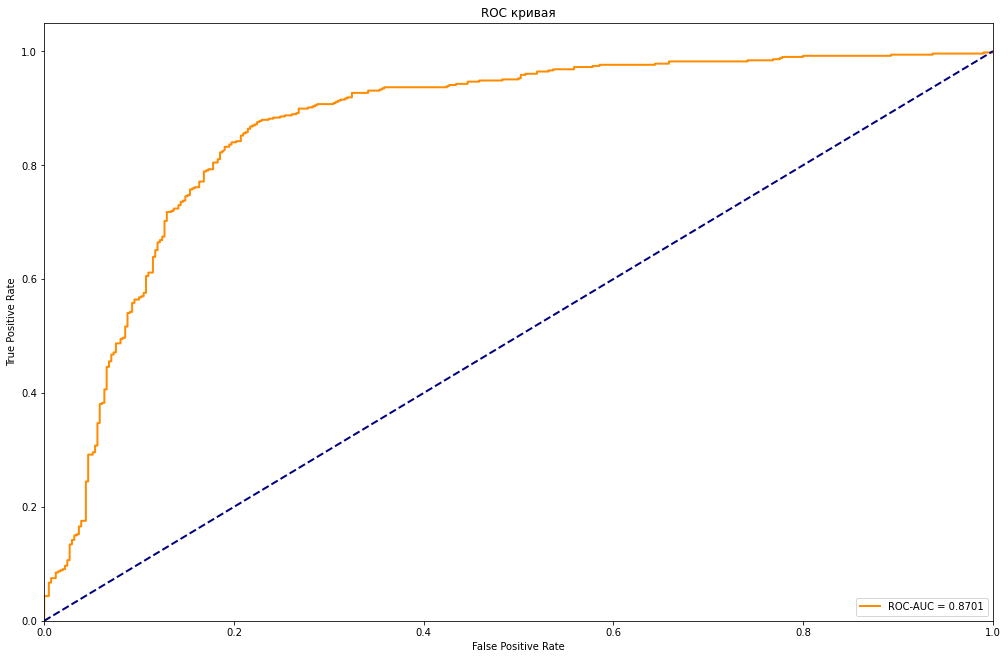

Wall time: 37.7 s


In [50]:
%%time

predictions = cross_val_predict(svm, X_dummy, y_dummy, n_jobs=-1)
print(classification_report(y_dummy, predictions))
    
predictions_proba = cross_val_predict(svm, X_dummy, y_dummy, n_jobs=-1, method='predict_proba')[:, 1]
plot_roc_auc(y_dummy, predictions_proba)

### Random Forest

              precision    recall  f1-score   support

           0       0.83      0.78      0.80       410
           1       0.83      0.87      0.85       507

    accuracy                           0.83       917
   macro avg       0.83      0.82      0.83       917
weighted avg       0.83      0.83      0.83       917



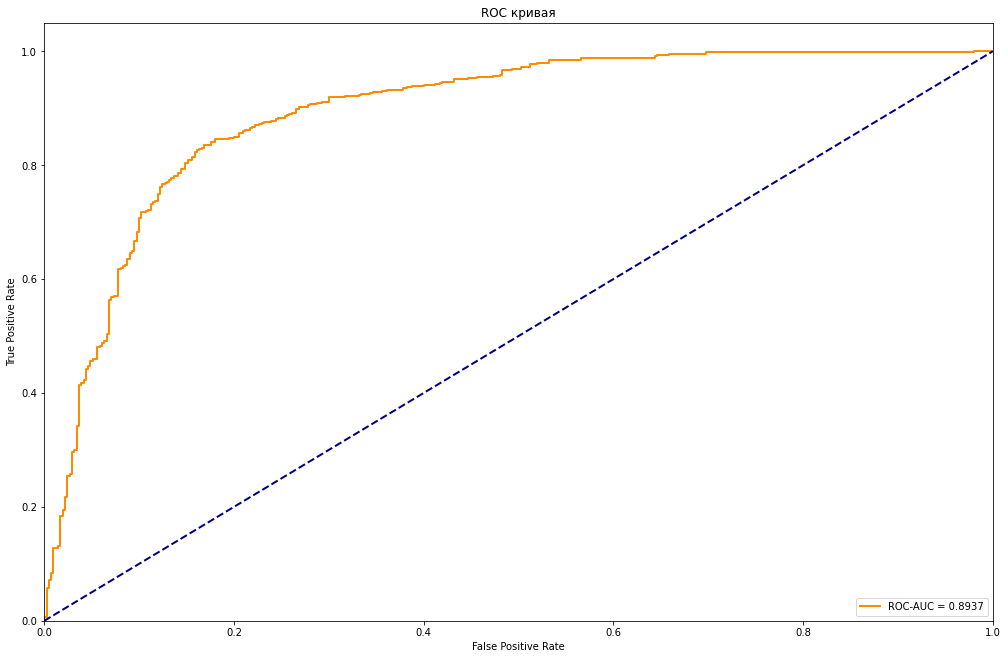

Wall time: 2.79 s


In [51]:
%%time

predictions = cross_val_predict(rf, X_dummy, y_dummy, n_jobs=-1)
print(classification_report(y_dummy, predictions))
    
predictions_proba = cross_val_predict(rf, X_dummy, y_dummy, n_jobs=-1, method='predict_proba')[:, 1]
plot_roc_auc(y_dummy, predictions_proba)

### Logistic Regression

              precision    recall  f1-score   support

           0       0.80      0.81      0.80       410
           1       0.84      0.83      0.84       507

    accuracy                           0.82       917
   macro avg       0.82      0.82      0.82       917
weighted avg       0.82      0.82      0.82       917



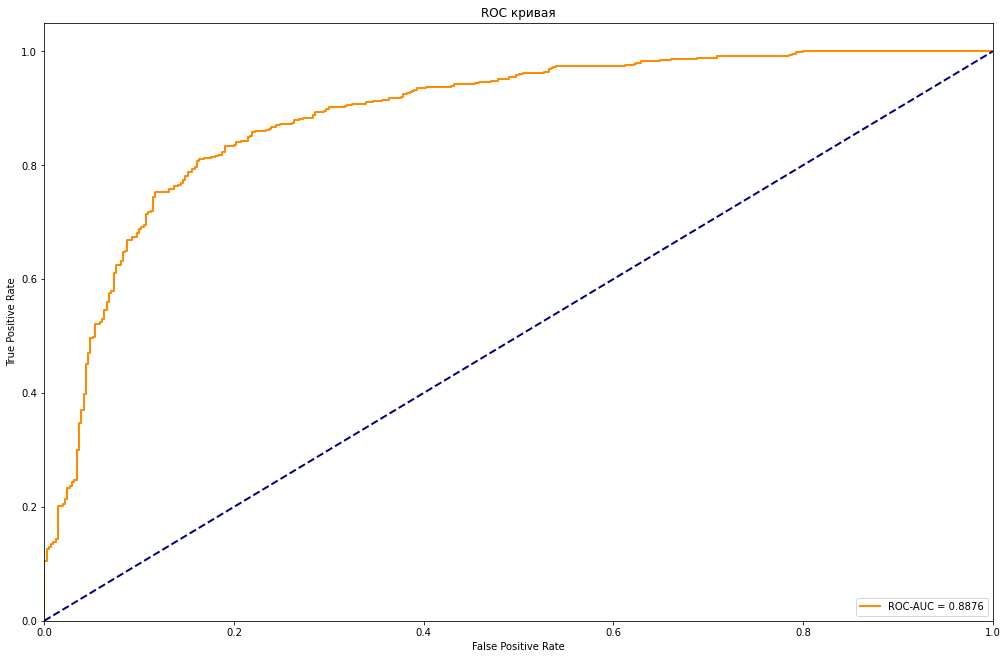

Wall time: 4.17 s


In [52]:
%%time

predictions = cross_val_predict(lr, X_dummy, y_dummy, n_jobs=-1)
print(classification_report(y_dummy, predictions))
    
predictions_proba = cross_val_predict(lr, X_dummy, y_dummy, n_jobs=-1, method='predict_proba')[:, 1]
plot_roc_auc(y_dummy, predictions_proba)

### Catboost

C:\Users\sereg\AppData\Roaming\Python\Python39\site-packages\catboost\core.py:1419: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, embedding_features_data, pairs, weight,


              precision    recall  f1-score   support

           0       0.82      0.80      0.81       410
           1       0.84      0.86      0.85       507

    accuracy                           0.83       917
   macro avg       0.83      0.83      0.83       917
weighted avg       0.83      0.83      0.83       917



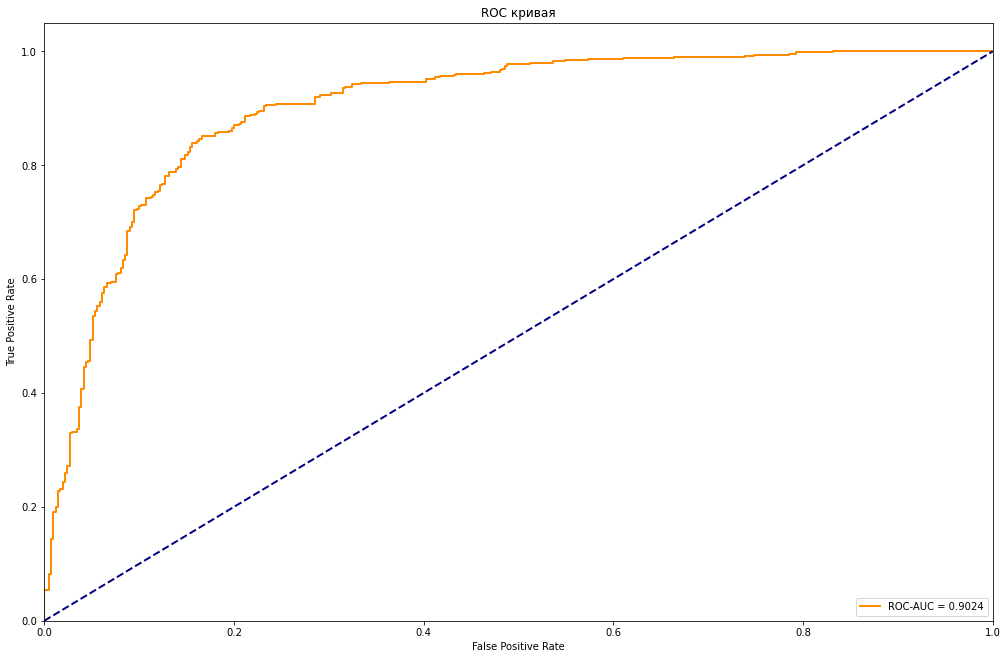

Wall time: 21.8 s


In [53]:
%%time
pool = cb.Pool(X, label=y, cat_features=cat_cols)

predictions = cross_val_predict(catboost, X, y, n_jobs=-1)
print(classification_report(y, predictions))

predictions_proba = cross_val_predict(catboost, X, y, n_jobs=-1, method='predict_proba')[:, 1]
plot_roc_auc(y, predictions_proba)

## Stacking models

## Final prediction